## Space invaders

In [1]:
import tensorflow as tf
import numpy as np
import gym
import os

#Plot
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Environment

In [2]:
environment = gym.make('SpaceInvaders-v0')

[2018-02-21 11:16:56,838] Making new env: SpaceInvaders-v0


In [3]:
observation = environment.reset()

Observations are 210X160 images with rgb

In [4]:
observation.shape

(210, 160, 3)

Action space is 6 (stop, shoot, right, right + shoot, left, left + shoot)

In [5]:
environment.action_space

Discrete(6)

### Start screen

In [6]:
def plot_environment(environment, figsize=(5,4)):
    plt.close()
    plt.figure(figsize=figsize)
    image = environment.render(mode="rgb_array")
    plt.imshow(image)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>


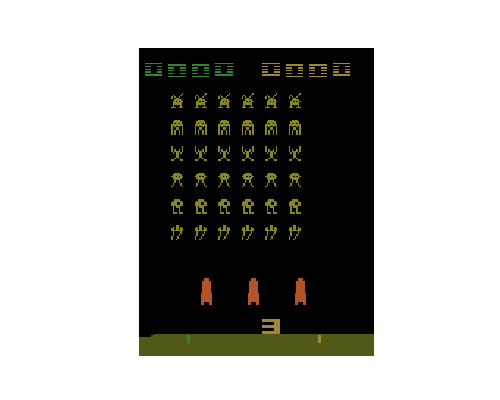

In [7]:
plot_environment(environment)

### Random game

In [8]:
frames = []

max_steps = 1000
change_action_step = 10

observation = environment.reset()

for step in range(max_steps):
    image = environment.render(mode="rgb_array")
    frames.append(image)
    if step % change_action_step == 0:
        action = environment.action_space.sample()
    observation, reward, done, info = environment.step(action)
    if done:
        break

In [9]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


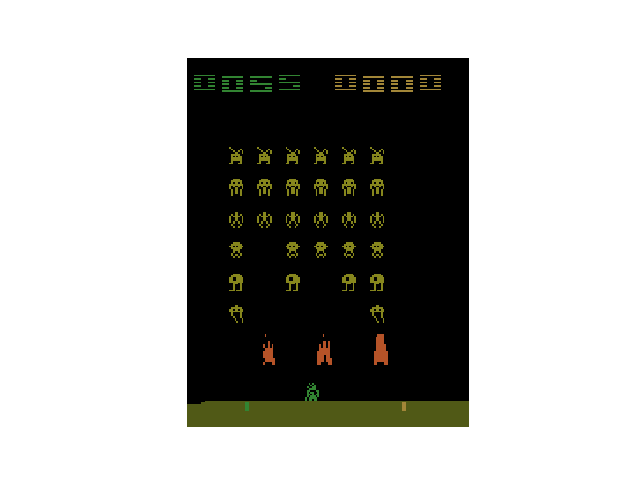

In [10]:
video = plot_animation(frames)
plt.show()

### Policy gradients

#### Image preprocessing

In [11]:
gym_environment = "SpaceInvaders-v0"
environment = gym.make(gym_environment)

[2018-02-21 11:23:24,643] Making new env: SpaceInvaders-v0


In [12]:
player_ship_color = np.array([51, 132, 50]).mean()

def preprocess_observation(observation, height, width):
    img = observation[1:176:2, ::2] # crop and downsize
    img = img.mean(axis=2) # to greyscale
    img[img==player_ship_color] = 0 # Improve contrast
    img = (img - 128) / 128 - 1 # normalize from -1. to 1.
    return img.reshape(height, width, 1)

observation = environment.reset()

image_height = 88
image_width = 80
image = preprocess_observation(observation, image_height, image_width)

<IPython.core.display.Javascript object>


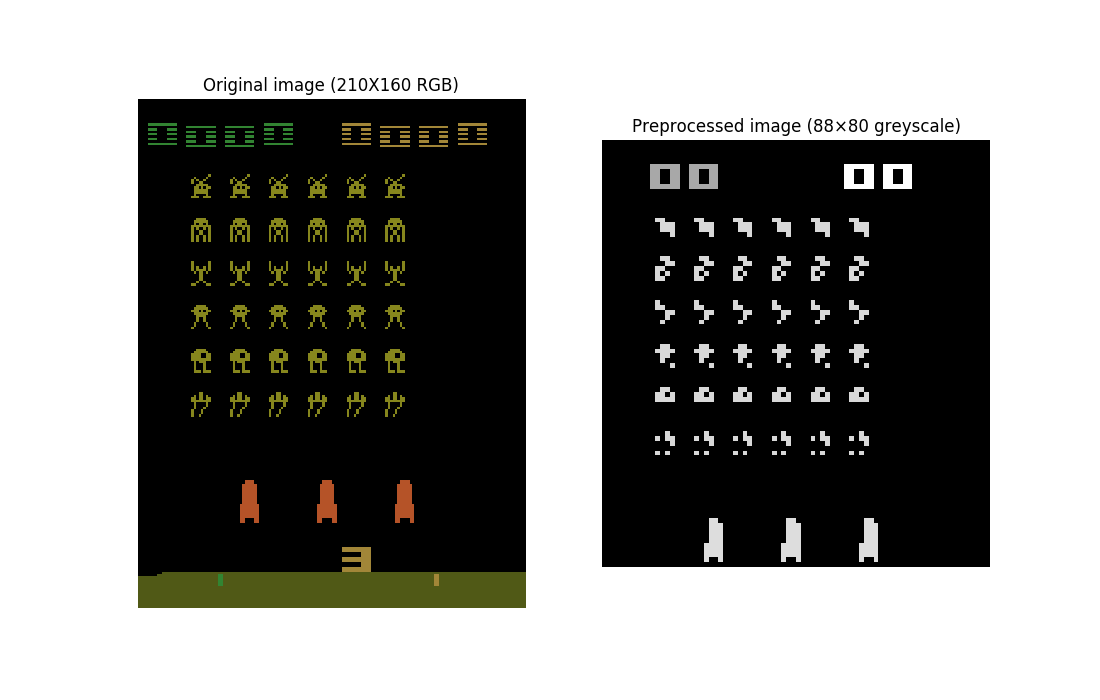

In [13]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original image (210X160 RGB)")
plt.imshow(observation)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed image (88×80 greyscale)")
plt.imshow(image.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

#### Policy network

In [14]:
tf.reset_default_graph()

input_height = image_height
input_width = image_width
input_channels = 1

#first convolution layer
conv1_n_maps = 32
conv1_kernel_sizes = (8,8)
conv1_strides = 4
#second convolution layer
conv2_n_maps = 64
conv2_kernel_sizes = (4,4)
conv2_strides = 2
#third convolution layer
conv3_n_maps = 64
conv3_kernel_sizes = (3,3)
conv3_strides = 1

conv_paddings = "SAME"
conv_activation = tf.nn.relu

n_hidden_inputs = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = environment.action_space.n
learning_rate = 0.01
initializer = tf.contrib.layers.variance_scaling_initializer()

X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])
conv_layer_1 = tf.layers.conv2d(X_state, filters=conv1_n_maps, kernel_size=conv1_kernel_sizes, 
                                strides=conv1_strides, padding=conv_paddings, activation=conv_activation, 
                                kernel_initializer=initializer)
conv_layer_2 = tf.layers.conv2d(conv_layer_1, filters=conv2_n_maps, kernel_size=conv2_kernel_sizes, 
                                strides=conv2_strides, padding=conv_paddings, activation=conv_activation, 
                                kernel_initializer=initializer)
conv_layer_3 = tf.layers.conv2d(conv_layer_2, filters=conv3_n_maps, kernel_size=conv3_kernel_sizes, 
                                strides=conv3_strides, padding=conv_paddings, activation=conv_activation, 
                                kernel_initializer=initializer)
conv_layer_3_flat = tf.reshape(conv_layer_3, shape=[-1, n_hidden_inputs])
hidden = tf.layers.dense(conv_layer_3_flat, n_hidden, activation=hidden_activation, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
output = tf.nn.softmax(logits)

action = tf.multinomial(tf.log(output), num_samples=1)

y = tf.one_hot(indices=[action], depth=n_outputs)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients_and_variables = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in gradients_and_variables]

gradient_placeholders = []
gradients_and_variables_feed = []

for grad, variable in gradients_and_variables:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    gradients_and_variables_feed.append((gradient_placeholder, variable))

training_optimize = optimizer.apply_gradients(gradients_and_variables_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [15]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std() if flat_rewards.std() != 0 else 1 # check for division by 0
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [16]:
number_of_games_per_update = 2
max_steps = 1000
number_of_iterations = 2
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(number_of_iterations):
        print("\rAt iteration: {} (of {})".format(iteration + 1 , number_of_iterations), end="")
        all_rewards = []
        all_gradients = []
        for game in range(number_of_games_per_update):
            current_rewards = []
            current_gradients = []
            observation = environment.reset()
            for step in range(max_steps):
                action_value, gradients_value = sess.run([action, gradients], 
                        feed_dict={X_state: [preprocess_observation(observation, input_height, input_width)]})
                observation, reward, done, info = environment.step(action_value[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_value)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_optimize, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./policy_net_pg.ckpt")

At iteration: 2 (of 2)

In [16]:
environment.close()

#### Playing a game

In [17]:
def render_policy_net(model_path, action, X, gym_environment, max_steps = 1000):
    frames = []
    total_reward = 0
    environment = gym.make(gym_environment)
    observation = environment.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(max_steps):
            frames.append(observation)
            action_value = action.eval(feed_dict={X_state: [preprocess_observation(observation, input_height, input_width)]})
            observation, reward, done, info = environment.step(action_value[0][0])
            total_reward += reward
            if done:
                break
    environment.close()
    return frames, total_reward        

[2018-02-21 11:23:53,196] Making new env: SpaceInvaders-v0


INFO:tensorflow:Restoring parameters from ./policy_net_pg.ckpt


[2018-02-21 11:23:53,376] Restoring parameters from ./policy_net_pg.ckpt


<IPython.core.display.Javascript object>


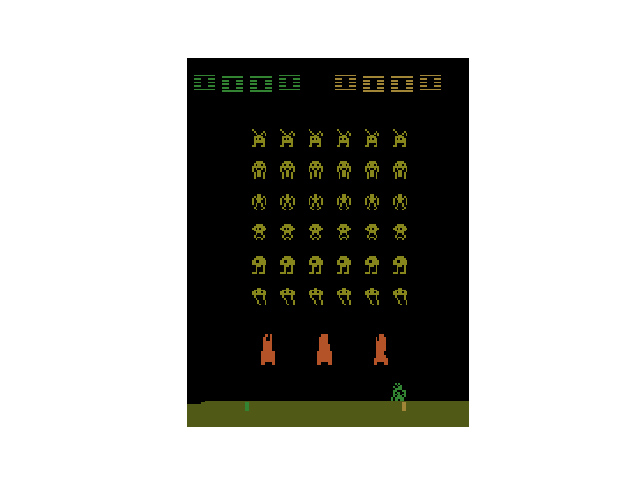

In [18]:
frames, reward = render_policy_net("./policy_net_pg.ckpt", action, X_state, "SpaceInvaders-v0", max_steps=1000)
video = plot_animation(frames)
plt.show()

### Q-Learning

#### Create DQN (Deep Q Network)

In [22]:
environment = gym.make(gym_environment)

[2017-11-13 08:57:56,431] Making new env: SpaceInvaders-v0


In [23]:
input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"]*3 
conv_activation = [tf.nn.relu]*3
n_hidden_inputs = 64 * 11 * 10  
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = environment.action_space.n
initializer = tf.contrib.layers.variance_scaling_initializer()

learning_rate = 0.01

def q_network(X_state, scope):
    prev_layer = X_state
    conv_layers = []
    with tf.variable_scope(scope) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(conv_n_maps, conv_kernel_sizes, conv_strides, conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(prev_layer, filters=n_maps, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation, kernel_initializer=initializer)
            conv_layers.append(prev_layer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_inputs])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden, activation=hidden_activation, kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs)
    trainable_vars = {var.name[len(scope.name):]: var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
    return outputs, trainable_vars

X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])
actor_q_values, actor_vars = q_network(X_state, scope="q_networks/actor")    # acts
critic_q_values, critic_vars = q_network(X_state, scope="q_networks/critic") # learns

copy_ops = [actor_var.assign(critic_vars[var_name])
            for var_name, actor_var in actor_vars.items()]
copy_critic_to_actor = tf.group(*copy_ops)

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(critic_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keep_dims=True)
    cost = tf.reduce_mean(tf.square(y - q_value))
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(cost, global_step=global_step)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [24]:
actor_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/actor/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/actor/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/actor/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/actor/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/actor/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/actor/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/actor/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/actor/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/actor/dense_1/bias:0' shape=(6,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/actor/dense_1/kern

In [36]:
from collections import deque

replay_memory_size = 10000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [37]:
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 50000
import sys

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

#### Train

In [38]:
n_steps = 100000  # total number of training steps
training_start = 1000  # start training after 1,000 game iterations
training_interval = 3  # run a training step every 3 game iterations
save_steps = 50  # save the model every 50 training steps
copy_steps = 25  # copy the critic to the actor every 25 training steps
discount_rate = 0.95
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

with tf.Session() as sess:
    if os.path.isfile(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f}%)".format(iteration, step, n_steps, step * 100 / n_steps), end="")
        if done: # game over, start again
            obs = environment.reset()
            for skip in range(skip_start): # skip boring game iterations at the start of each game
                obs, reward, done, info = environment.step(0)
            state = preprocess_observation(obs, input_height, input_width)

        # Actor evaluates what to do
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Actor plays
        obs, reward, done, info = environment.step(action)
        next_state = preprocess_observation(obs, input_height, input_width)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        if iteration < training_start or iteration % training_interval != 0:
            continue
        
        # Critic learns
        X_state_val, X_action_val, rewards, X_next_state_val, continues = sample_memories(batch_size)
        next_q_values = actor_q_values.eval(feed_dict={X_state: X_next_state_val})
        y_val = rewards + continues * discount_rate * np.max(next_q_values, axis=1, keepdims=True)
        training_op.run(feed_dict={X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy critic to actor
        if step % copy_steps == 0:
            copy_critic_to_actor.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

Iteration 300999	Training step 99999/100000 (100.0%)

#### Playing a game

In [19]:
def render_dqn_net(model_path, action, X, gym_environment, max_steps = 1000):
    frames = []
    total_reward = 0
    environment = gym.make(gym_environment)
    observation = environment.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(max_steps):
            frames.append(observation)
            action_value = action.eval(feed_dict={X_state: [preprocess_observation(observation, input_height, input_width)]})
            observation, reward, done, info = environment.step(action_value[0][0])
            total_reward += reward
            if done:
                break
    environment.close()
    return frames, total_reward   

[2018-02-21 11:50:29,066] Making new env: SpaceInvaders-v0


INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


[2018-02-21 11:50:29,255] Restoring parameters from ./my_dqn.ckpt


<IPython.core.display.Javascript object>


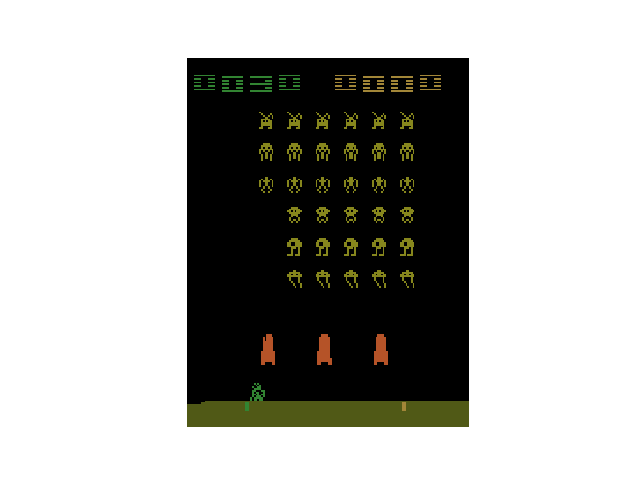

In [20]:
frames, reward = render_dqn_net("./my_dqn.ckpt", action, X_state, "SpaceInvaders-v0", max_steps=1000)
video = plot_animation(frames)
plt.show()